Детектор аномалии на принципе многократной прогонки реконструкции входного образца до сходимости латентного вектора.
Критерий аномальности - расстояние от первоначального латентного вектора до сошедшего.

In [1]:
from dataclasses import dataclass
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np 
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from tqdm.auto import tqdm
from torchfuzzy import FuzzyLayer, DefuzzyLinearLayer, FuzzyBellLayer
import piqa
import sklearn.metrics as metrics
from sklearn.manifold import TSNE
from torchvision.transforms import v2
from torchinfo import summary

In [2]:
batch_size = 256
learning_rate = 1e-3
num_epochs = 100
latent_dim = 7
mnist_class_anomaly = 4
kernels = 16
fuzzy_rules_count = 32

prefix = f"fuzzy_ad"
writer = SummaryWriter(f'runs/mnist/{prefix}_{datetime.now().strftime("%Y%m%d-%H%M%S")}')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ssim = piqa.SSIM(window_size = 11, n_channels=1, reduction='none').to(device)
device

device(type='cuda')

## Датасет

1. Исключаем класс аномалии `mnist_class_anomaly` из общей выборк
2. Убираем метки с остальных классов
   

In [3]:
def norm_and_transform(x):
    nimg = x.view(-1, 28, 28)
    nimg = torch.clamp(nimg, 0, 1)
    return nimg

def clamp(x):
    #nimg = 2.0*(x.view(-1, 28, 28) - 0.5)
    nimg = torch.clamp(x, 0, 1)
    return nimg

transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(norm_and_transform)
])

augmentation = transforms.Compose([
    transforms.RandomRotation(15, fill=0), 
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), fill=0), 
    #transforms.RandomCrop(size=26),
    #transforms.Resize(size=(28, 28)),
    transforms.Lambda(clamp)
])

In [4]:
def get_target_and_mask(target_label):
    t = target_label
    return t 

train_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=True, 
    transform = transform,
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x))
)

idx = (train_data.targets != mnist_class_anomaly)
train_data.targets = train_data.targets[idx]
train_data.data = train_data.data[idx]
len(train_data)

54158

загружаем тестовую выборку

In [5]:
test_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=False, 
    transform=transform, 
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x))
)
len(test_data)

10000

Создаем итераторы датасетов

In [6]:

train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size=batch_size, 
    shuffle=True,
    
)
test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size=batch_size, 
    shuffle=False,
)

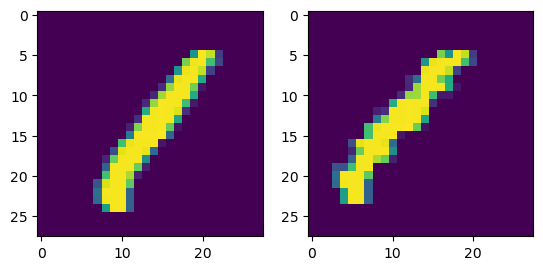

In [7]:
for data,_ in iter(train_loader):
    R, C = 1, 2
    plt.subplot(R, C, 1)
    plt.imshow(data[0].squeeze())
    plt.subplot(R, C, 2)
    plt.imshow(augmentation(data)[0].squeeze())
    
    
    break

## Модель

In [8]:
class Encoder(nn.Module):
    """
    Компонент энкодера для VAE
    
    Args:
        latent_dim (int): Размер латентного вектора.
    """
    
    def __init__(self, latent_dim, kernels):
        super(Encoder, self).__init__()
                
        
        self.latent = nn.Sequential(
            nn.Conv2d(1, kernels, kernel_size = 5), 
            nn.Conv2d(kernels, kernels, kernel_size = 5), 
            nn.BatchNorm2d(kernels), 
            nn.SiLU(),

            nn.Conv2d(kernels, 2*kernels, kernel_size = 5), 
            nn.Conv2d(2*kernels, 2*kernels, kernel_size = 5), 
            nn.BatchNorm2d(2*kernels), 
            nn.SiLU(),

            nn.Conv2d(2*kernels, 4*kernels, kernel_size = 5), 
            nn.Conv2d(4*kernels, 4*kernels, kernel_size = 5), 
            nn.BatchNorm2d(4*kernels), 
            nn.SiLU(),

            nn.Conv2d(4*kernels, 8*kernels, kernel_size = 4), 
            nn.BatchNorm2d(8*kernels), 
            nn.SiLU(),
            
            nn.Flatten(),
            nn.Linear(8*kernels, latent_dim)
        )

        self.fuzzy = nn.Sequential(
            FuzzyBellLayer.from_dimensions(latent_dim, fuzzy_rules_count)
        )

    def forward(self, x):
        """
        Выход энкодера для чистого VAE.
        
        Args:
            x (torch.Tensor): Входной вектор.
            eps (float): Небольшая поправка к скейлу для лучшей сходимости и устойчивости.
        
        Returns:
            mu, logvar, z, dist
        """
        latent = self.latent(x)
        fz = self.fuzzy(latent)
        return fz, latent

inp = torch.rand(10, 1, 28, 28)
m = Encoder(latent_dim, 16)
mu = m.forward(inp)

summary(m, input_size=(batch_size, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Encoder                                  [256, 32]                 --
├─Sequential: 1-1                        [256, 7]                  --
│    └─Conv2d: 2-1                       [256, 16, 24, 24]         416
│    └─Conv2d: 2-2                       [256, 16, 20, 20]         6,416
│    └─BatchNorm2d: 2-3                  [256, 16, 20, 20]         32
│    └─SiLU: 2-4                         [256, 16, 20, 20]         --
│    └─Conv2d: 2-5                       [256, 32, 16, 16]         12,832
│    └─Conv2d: 2-6                       [256, 32, 12, 12]         25,632
│    └─BatchNorm2d: 2-7                  [256, 32, 12, 12]         64
│    └─SiLU: 2-8                         [256, 32, 12, 12]         --
│    └─Conv2d: 2-9                       [256, 64, 8, 8]           51,264
│    └─Conv2d: 2-10                      [256, 64, 4, 4]           102,464
│    └─BatchNorm2d: 2-11                 [256, 64, 4, 4]        

In [9]:
class Decoder(nn.Module):
    """
    Компонент декодера для VAE
    
    Args:
        latent_dim (int): Размер латентного вектора.
    """
    
    def __init__(self, fuzzy_rules_count, kernels):
        super(Decoder, self).__init__()

        self.decode = nn.Sequential(
            nn.Linear(fuzzy_rules_count, 8*kernels),
            nn.BatchNorm1d(8*kernels),
            nn.Unflatten(1, (8*kernels, 1, 1)),
            
            nn.ConvTranspose2d(8*kernels, 4*kernels, 4),
            nn.BatchNorm2d(4*kernels),
            nn.SiLU(),

            nn.ConvTranspose2d(4*kernels, 2*kernels, 5),
            nn.ConvTranspose2d(2*kernels, 2*kernels, 5),
            nn.BatchNorm2d(2*kernels),
            nn.SiLU(),

            nn.ConvTranspose2d(2*kernels, kernels, 5),
            nn.ConvTranspose2d(kernels, kernels, 5),
            nn.BatchNorm2d(kernels),
            nn.SiLU(),

            nn.ConvTranspose2d(kernels, kernels, 5),
            nn.ConvTranspose2d(kernels, 1, 5),
            nn.BatchNorm2d(1),
            nn.SiLU(),
        )
        
         
    def forward(self, z):
        """
        Декодирует латентный вектор в исходное представление
        
        Args:
            z (torch.Tensor): Латентный вектор.
        
        Returns:
            x
        """
        out = self.decode(z)
        out = out.clamp(0, 1)
        return out
    
    
inp = torch.rand(batch_size, fuzzy_rules_count)
m = Decoder(fuzzy_rules_count, 16)
mu = m.forward(inp)
mu[0].shape

summary(m, input_size=(batch_size, fuzzy_rules_count))

Layer (type:depth-idx)                   Output Shape              Param #
Decoder                                  [256, 1, 28, 28]          --
├─Sequential: 1-1                        [256, 1, 28, 28]          --
│    └─Linear: 2-1                       [256, 128]                4,224
│    └─BatchNorm1d: 2-2                  [256, 128]                256
│    └─Unflatten: 2-3                    [256, 128, 1, 1]          --
│    └─ConvTranspose2d: 2-4              [256, 64, 4, 4]           131,136
│    └─BatchNorm2d: 2-5                  [256, 64, 4, 4]           128
│    └─SiLU: 2-6                         [256, 64, 4, 4]           --
│    └─ConvTranspose2d: 2-7              [256, 32, 8, 8]           51,232
│    └─ConvTranspose2d: 2-8              [256, 32, 12, 12]         25,632
│    └─BatchNorm2d: 2-9                  [256, 32, 12, 12]         64
│    └─SiLU: 2-10                        [256, 32, 12, 12]         --
│    └─ConvTranspose2d: 2-11             [256, 16, 16, 16]         

In [10]:
class VAE(nn.Module):
    """
    Args:
        latent_dim (int): Размер латентного вектора.
    """
    def __init__(self, latent_dim, fuzzy_rules_count, kernels):
        super(VAE, self).__init__()

        self.encoder = Encoder(latent_dim, kernels)        
        self.decoder = Decoder(fuzzy_rules_count, kernels)
        self.ad_score = nn.Sequential(
            nn.Linear(fuzzy_rules_count, 1, bias=False),
        )

    def forward(self, x):
        """
        
        """
        fz, mu = self.encoder(x)
        x_recon = self.decoder(fz)
        
        return fz, mu, x_recon
    
    def half_pass(self, x):
        """
        
        """
        fz, mu = self.encoder(x)
        return fz, mu
    
    def decoder_pass(self, x):
        r = self.decoder(x)
        return r
    
    def get_score(self, x):
        fz, mu = self.encoder(x)
        score = self.ad_score(fz)
        return score


## Обучение

In [11]:
model = VAE(latent_dim=latent_dim, fuzzy_rules_count=fuzzy_rules_count, kernels=kernels).to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params:,}')

summary(model, input_size=(batch_size, 1,28, 28))

Number of parameters: 571,546


Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [256, 32]                 32
├─Encoder: 1-1                           [256, 32]                 --
│    └─Sequential: 2-1                   [256, 7]                  --
│    │    └─Conv2d: 3-1                  [256, 16, 24, 24]         416
│    │    └─Conv2d: 3-2                  [256, 16, 20, 20]         6,416
│    │    └─BatchNorm2d: 3-3             [256, 16, 20, 20]         32
│    │    └─SiLU: 3-4                    [256, 16, 20, 20]         --
│    │    └─Conv2d: 3-5                  [256, 32, 16, 16]         12,832
│    │    └─Conv2d: 3-6                  [256, 32, 12, 12]         25,632
│    │    └─BatchNorm2d: 3-7             [256, 32, 12, 12]         64
│    │    └─SiLU: 3-8                    [256, 32, 12, 12]         --
│    │    └─Conv2d: 3-9                  [256, 64, 8, 8]           51,264
│    │    └─Conv2d: 3-10                 [256, 64, 4, 4]           10

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, learning_rate, epochs=num_epochs, steps_per_epoch=len(train_loader))
#sched = torch.optim.lr_scheduler.ConstantLR(optimizer, learning_rate)

In [13]:
def compute_vae_loss(x, recon_x):
    loss_recon = (x - recon_x).square()#(1 - ssim(recon_x, x))
    loss_recon = loss_recon.sum(-1).sum(-1).mean()
    return loss_recon
    

In [14]:
def compute_fuzzy_loss(fz):
    return (1 - fz.sum(-1)).square().mean() #(0.999 - (tops[:,0]+tops[:,1]).clamp(max=0.999)).mean() + tops[:, 2].clamp(min=0.001).mean()

In [15]:
def keep_eigenvals_positive_loss(layer, eps = 1e-15):
    ev = layer.get_transformation_matrix_eigenvals().real.min()
    ev = torch.clamp(ev, max=eps)
    return -ev

In [16]:
1000 - model.encoder.fuzzy[0].get_transformation_matrix_eigenvals().real.sum(-1)

tensor([993., 993., 993., 993., 993., 993., 993., 993., 993., 993., 993., 993.,
        993., 993., 993., 993., 993., 993., 993., 993., 993., 993., 993., 993.,
        993., 993., 993., 993., 993., 993., 993., 993.], device='cuda:0',
       grad_fn=<RsubBackward1>)

In [17]:
def fuzzy_term_volume_loss(layer, fz):
    ev = layer.get_transformation_matrix_eigenvals().real.sum(-1)
    ev = ev.log().mean()
    ev = -ev.clamp(max = 3)
    
    #loss = fz.quantile(0.5, -1).abs().mean() + ev
    return ev

In [18]:
def get_arate(inp):
    fz, mu, x_recon = model.forward(inp)
    
    return fz.sum(-1).cpu().numpy() #(1 - ssim(x_recon.clamp(0, 1), inp)).cpu().numpy()#xent_continuous_ber((x_recon + 1)/2, (inp + 1)/2).cpu().numpy()# #ssim((inp + 1)/2, (recon_x+1)/2).cpu().numpy() #fz.sum(-1).cpu().numpy()#

In [19]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
def train(model, dataloader, optimizer, sched, prev_updates, epoch, writer=None):
    model.train()  
    
    for batch_idx, (data, _) in enumerate(tqdm(dataloader, disable=True)):
        n_upd = prev_updates + batch_idx
        
        data = data.to(device)
        adata = augmentation(data)
        
        optimizer.zero_grad()  
        
        fz, mu = model.half_pass(adata)  
        x_reconstruct = model.decoder_pass(fz)
        
        loss_reconstruct = compute_vae_loss(data, x_reconstruct)
        fz_loss = fuzzy_term_volume_loss(model.encoder.fuzzy[0], fz)
        
        #ev_loss = keep_eigenvals_positive_loss(model.encoder.fuzzy[0])
        #if ev_loss.item() > 0:
        #    ev_loss.backward(retain_graph=True)
        
        fz_loss.backward(retain_graph=True)
        loss_reconstruct.backward()
        
        optimizer.step()  
        
        if sched is not None:
            sched.step()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 10)    
        
    if writer is not None:
        writer.add_scalar('FAD/LR', get_lr(optimizer), global_step=epoch)
        
    return prev_updates + len(dataloader)

In [20]:
fixed_random_z = torch.randn(16, fuzzy_rules_count).to(device)

def test(model, dataloader, cur_step, epoch, writer=None):
    model.eval() 

    test_recon_loss = 0
    test_fz_loss = 0
    
    lab_true = []
    lab_pred = []

    with torch.no_grad():
        for data, lab in tqdm(test_loader, desc='Test MNIST', disable=True):
            data = data.view((-1,1,28,28)).to(device)
            rates = get_arate(data)
            
            for f, l in  zip(rates, lab):
                lab_pred.append(f)        
                if l == mnist_class_anomaly:
                    lab_true.append(1)
                else:
                    lab_true.append(0)
                        
    fpr, tpr, _ = metrics.roc_curve(lab_true, lab_pred)
    roc_auc = metrics.auc(fpr, tpr)
    
    embedings = []
    labels_expected = []
    centroids = model.encoder.fuzzy[0].get_centroids().detach().cpu().numpy()
    
    with torch.no_grad():
        for data, target in tqdm(dataloader, desc='Testing', disable=True):
            data = data.to(device)

            fz, mu = model.half_pass(data)  
            x_reconstruct = model.decoder_pass(fz)
            
            embedings.append(mu.cpu().numpy())
            labels_expected.append(target.cpu().numpy())

            loss_recon = compute_vae_loss(data, x_reconstruct)
            fz_loss = fuzzy_term_volume_loss(model.encoder.fuzzy[0], fz)
            
            test_recon_loss += loss_recon.item()
            test_fz_loss += fz_loss.item()
            

    embedings = np.concatenate(embedings, axis=0)
    labels_expected = np.concatenate(labels_expected, axis=0)

    if epoch % 5 == 1:
        plt.figure(figsize=(18, 6))

        R, C = 1, 3

        plt.subplot(R, C, 1)
        plt.title("MNIST XY")
        plt.scatter(embedings[:, 0],      embedings[:,  1], c=labels_expected, cmap='tab10', s=2)
        plt.scatter(centroids[:, 0],      centroids[:, 1], marker='1', c='black', s= 50)
        #plt.scatter(centroids_resd[:, 0],      centroids_resd[:, 1], marker='2', c='red', s= 20)
        
        # plt.xlim((-1, 1))
        # plt.ylim((-1, 1))

        plt.subplot(R, C, 2)
        plt.title("MNIST XZ")
        plt.scatter(embedings[:, 0],      embedings[:,  2], c=labels_expected, cmap='tab10', s=2)
        plt.scatter(centroids[:, 0],      centroids[:, 2], marker='1', c='black', s= 50)
        #plt.scatter(centroids_resd[:, 0], centroids_resd[:, 2], marker='2', c='red', s= 20)
        
        # plt.xlim((-1, 1))
        # plt.ylim((-1, 1))

        plt.show()
    
    test_recon_loss /= len(dataloader)
    test_fz_loss /= len(dataloader)
    
    print(f'[{cur_step}] Reconstruction loss: {test_recon_loss:.4f}, VOL: {test_fz_loss:.4f} AUC: {roc_auc:.4f}')
    #print(f'Average activation stats: {model.decoder.fuzzy[2].get_norm_stats()}')
    #print(f'Average centroid stats: {model.decoder.fuzzy[0].get_average_centroid()}')
    if writer is not None:
        writer.add_scalar('FAD/AUC', roc_auc, global_step=cur_step)
        writer.add_scalar('FAD/Reconstruction', test_recon_loss, global_step=cur_step)
        writer.add_scalar('FAD/Fz', test_fz_loss, global_step=cur_step)
        
        samples = model.decoder_pass(fixed_random_z)
        writer.add_images('FAD/Samples', samples.view(-1, 1, 28, 28), global_step=cur_step)

In [21]:
prev_updates = 0

[212] Reconstruction loss: 44.2479, VOL: -1.9469 AUC: 0.4372


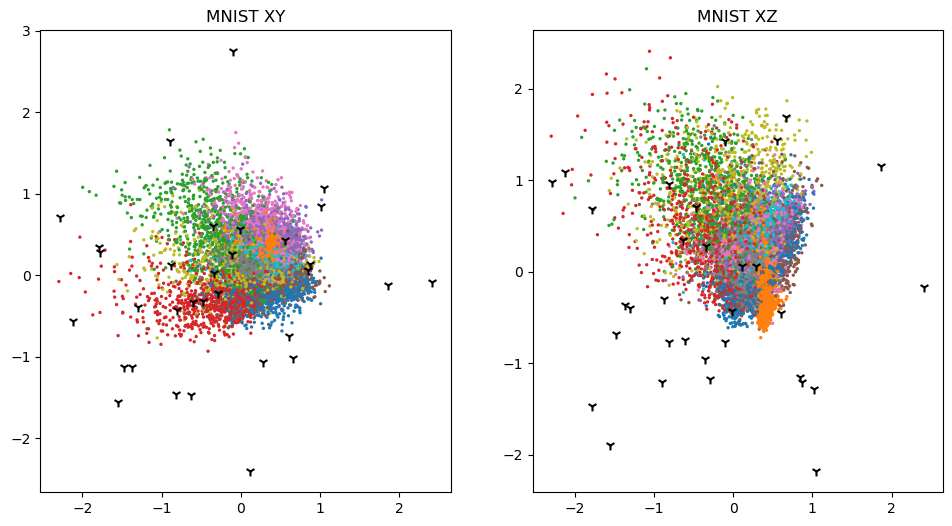

[424] Reconstruction loss: 34.6618, VOL: -1.9485 AUC: 0.4632
[636] Reconstruction loss: 29.7785, VOL: -1.9502 AUC: 0.5252
[848] Reconstruction loss: 30.5373, VOL: -1.9523 AUC: 0.4802
[1060] Reconstruction loss: 26.2629, VOL: -1.9548 AUC: 0.6063
[1272] Reconstruction loss: 25.5212, VOL: -1.9578 AUC: 0.5417


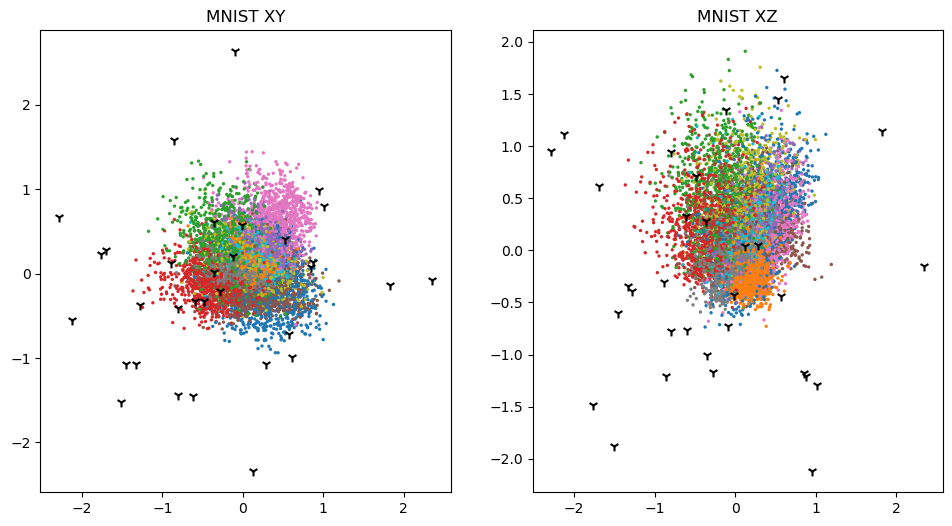

[1484] Reconstruction loss: 30.2605, VOL: -1.9614 AUC: 0.5120
[1696] Reconstruction loss: 24.1427, VOL: -1.9655 AUC: 0.5810
[1908] Reconstruction loss: 24.4145, VOL: -1.9702 AUC: 0.5870
[2120] Reconstruction loss: 22.0138, VOL: -1.9754 AUC: 0.5934
[2332] Reconstruction loss: 24.4143, VOL: -1.9810 AUC: 0.6438


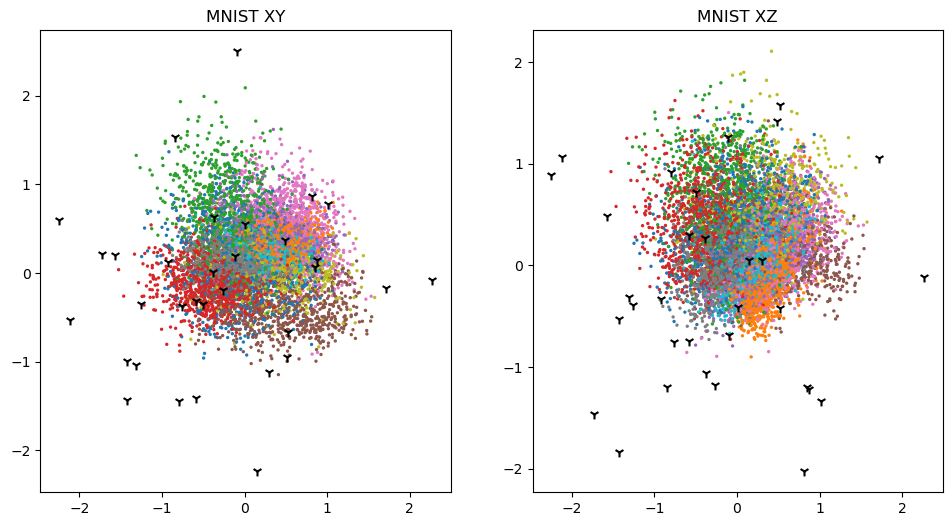

[2544] Reconstruction loss: 22.6557, VOL: -1.9873 AUC: 0.5643
[2756] Reconstruction loss: 22.2829, VOL: -1.9938 AUC: 0.6667
[2968] Reconstruction loss: 25.7527, VOL: -2.0005 AUC: 0.6799
[3180] Reconstruction loss: 25.3772, VOL: -2.0077 AUC: 0.7065
[3392] Reconstruction loss: 23.3465, VOL: -2.0151 AUC: 0.7465


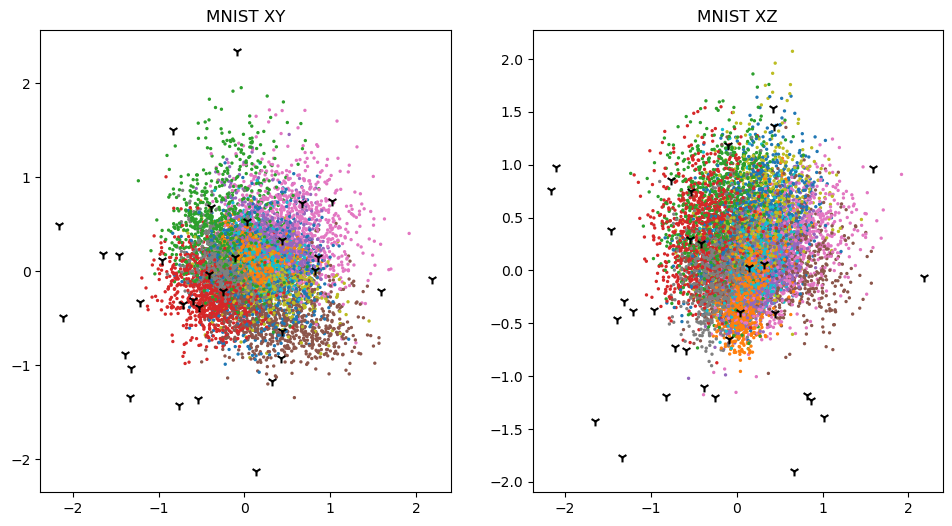

[3604] Reconstruction loss: 26.5185, VOL: -2.0228 AUC: 0.5994
[3816] Reconstruction loss: 25.6547, VOL: -2.0307 AUC: 0.6481
[4028] Reconstruction loss: 19.5637, VOL: -2.0385 AUC: 0.7145
[4240] Reconstruction loss: 27.1095, VOL: -2.0469 AUC: 0.7209
[4452] Reconstruction loss: 28.3506, VOL: -2.0550 AUC: 0.6297


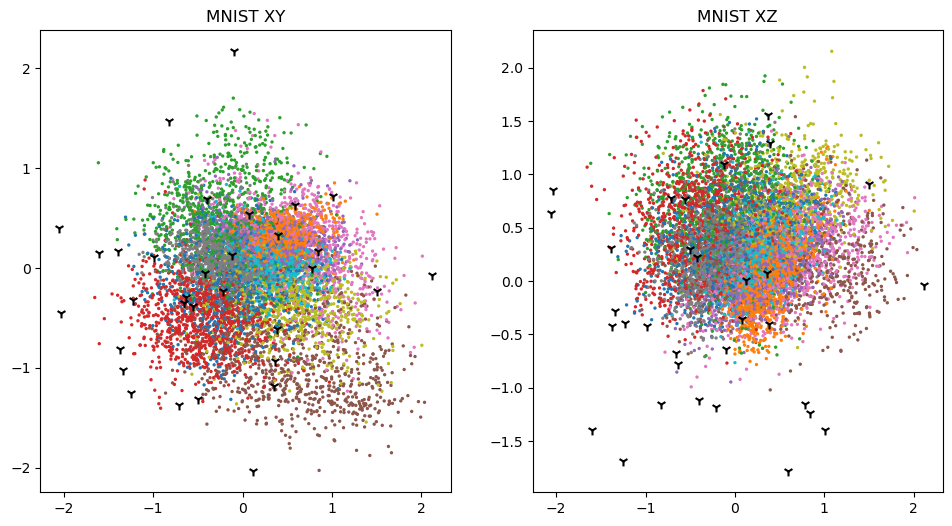

[4664] Reconstruction loss: 25.2853, VOL: -2.0633 AUC: 0.7509
[4876] Reconstruction loss: 21.8092, VOL: -2.0716 AUC: 0.7499
[5088] Reconstruction loss: 20.6149, VOL: -2.0801 AUC: 0.7485
[5300] Reconstruction loss: 21.7574, VOL: -2.0884 AUC: 0.7564
[5512] Reconstruction loss: 26.9359, VOL: -2.0970 AUC: 0.7895


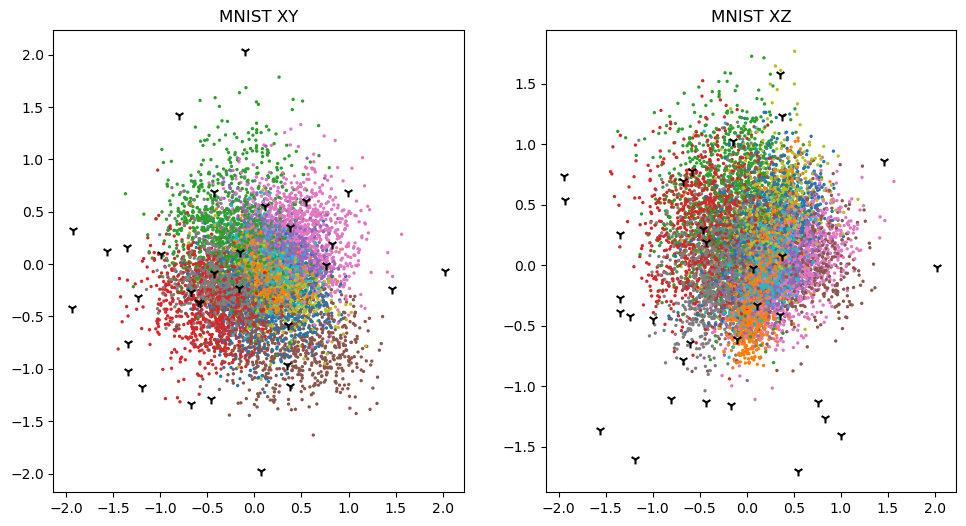

[5724] Reconstruction loss: 24.4348, VOL: -2.1058 AUC: 0.7250
[5936] Reconstruction loss: 26.6202, VOL: -2.1142 AUC: 0.7385
[6148] Reconstruction loss: 18.0388, VOL: -2.1226 AUC: 0.7888
[6360] Reconstruction loss: 18.3863, VOL: -2.1307 AUC: 0.7579
[6572] Reconstruction loss: 19.6560, VOL: -2.1388 AUC: 0.8225


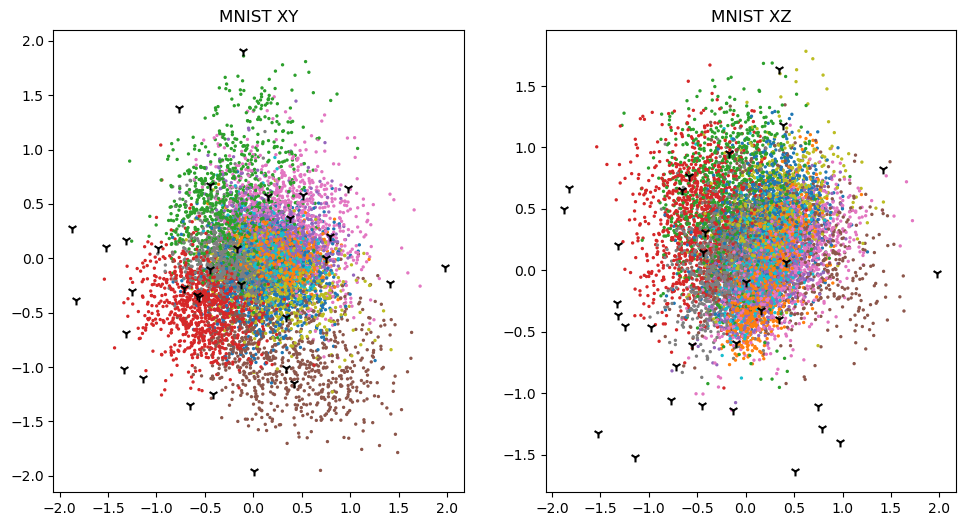

[6784] Reconstruction loss: 18.2990, VOL: -2.1469 AUC: 0.7835
[6996] Reconstruction loss: 19.1994, VOL: -2.1550 AUC: 0.7786
[7208] Reconstruction loss: 19.8067, VOL: -2.1626 AUC: 0.7861
[7420] Reconstruction loss: 20.4122, VOL: -2.1701 AUC: 0.7842
[7632] Reconstruction loss: 22.0112, VOL: -2.1778 AUC: 0.7944


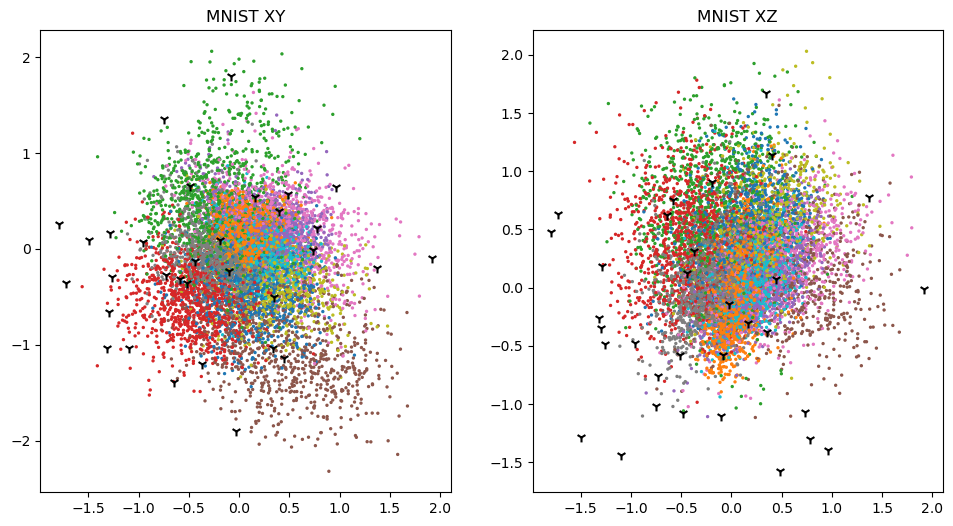

[7844] Reconstruction loss: 23.9785, VOL: -2.1850 AUC: 0.7850
[8056] Reconstruction loss: 23.1776, VOL: -2.1922 AUC: 0.7522


In [ ]:
for epoch in range(num_epochs):
    prev_updates = train(model, train_loader, optimizer, sched, prev_updates, epoch, writer=writer)
    test(model, test_loader, prev_updates, epoch, writer=writer)
    #scheduler.step()
    


In [ ]:
keep_eigenvals_positive_loss(model.encoder.fuzzy[0])

In [ ]:
model.encoder.fuzzy[0].get_transformation_matrix_eigenvals().real

In [ ]:
def train_ad(model, dataloader, optimizer, sched, prev_updates, epoch, writer=None):
    model.train()  
    for param in model.encoder.parameters():
        param.requires_grad = False
    
    for batch_idx, (data, _) in enumerate(tqdm(dataloader, disable=True)):
        n_upd = prev_updates + batch_idx
        
        data = data.to(device)
        adata = augmentation(data)
        
        optimizer.zero_grad()  
        
        score = model.get_score(adata)  
        
        (1 - score).square().mean().backward()
        
        optimizer.step()  
        
        if sched is not None:
            sched.step()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 10)    
        
    if writer is not None:
        writer.add_scalar('FAD/LR', get_lr(optimizer), global_step=epoch)
        
    return prev_updates + len(dataloader)

In [ ]:
def test_ad(model, dataloader, cur_step, epoch, writer=None):
    model.eval() 

    lab_true = []
    lab_pred = []

    with torch.no_grad():
        for data, lab in tqdm(test_loader, desc='Test MNIST', disable=True):
            data = data.view((-1,1,28,28)).to(device)
            rates = model.get_score(data).detach().cpu().numpy()
            
            for f, l in  zip(rates, lab):
                lab_pred.append(f)        
                if l == mnist_class_anomaly:
                    lab_true.append(1)
                else:
                    lab_true.append(0)
                        
    fpr, tpr, _ = metrics.roc_curve(lab_true, lab_pred)
    roc_auc = metrics.auc(fpr, tpr)
    
    print(f'[{cur_step}] AUC: {roc_auc:.4f}')
    
    if writer is not None:
        writer.add_scalar('FAD/AUC', roc_auc, global_step=cur_step)

In [ ]:
sched = torch.optim.lr_scheduler.ConstantLR(optimizer, learning_rate)

for epoch in range(num_epochs):
    prev_updates = train_ad(model, train_loader, optimizer, sched, prev_updates, epoch, writer=writer)
    test_ad(model, test_loader, prev_updates, epoch, writer=writer)
    

In [ ]:
model.encoder.fuzzy[0].get_transformation_matrix_eigenvals().real

## Визуализируем результаты

In [ ]:

def get_activation_stats(model, dataloader):
    rulestat = {}
    with torch.no_grad():
        for _, (data, _) in enumerate(tqdm(dataloader)):
            data = data.to(device)
            fz, mu, rec_x = model.forward(data)
            act_fz = fz.max(-1).indices.cpu().numpy()
            for ind in act_fz:
                rulestat[ind] = rulestat.get(ind, 0) + 1
    return rulestat

train_stat = get_activation_stats(model, train_loader)
test_stat = get_activation_stats(model, test_loader)

plt.bar(list(train_stat.keys()), train_stat.values(), 0.5, color='g')
plt.bar(list(test_stat.keys()), test_stat.values(), 0.5, color='r')

In [ ]:

def get_activation_stats_by_digit(digit, model, dataloader):
    rulestat = {}
    with torch.no_grad():
        for _, (data, target) in enumerate(tqdm(dataloader)):
        
            data = data.to(device)
            fz, mu, rec_x = model.forward(data)
            act_fz = fz.max(-1).indices.cpu().numpy()
            for ind, trg in zip(act_fz, target):
                if trg == digit:
                    rulestat[ind] = rulestat.get(ind, 0) + 1
    return rulestat


test_stat_by_digit = get_activation_stats_by_digit(9, model, test_loader)

plt.bar(list(test_stat_by_digit.keys()), test_stat_by_digit.values(), 0.5, color='r')
plt.xlim((-1, fuzzy_rules_count + 1))

In [ ]:
test_stat_by_digit

In [ ]:
z = torch.randn(64, fuzzy_rules_count).to(device)
samples = model.decoder_pass(z)

# Plot the generated images
fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(samples[i*8+j].view(28, 28).cpu().detach().numpy(), cmap='gray')
        ax[i, j].axis('off')


In [ ]:
ssim = piqa.SSIM(window_size = 9, n_channels=1, reduction='none').to(device)
def get_arate(inp):
    fz, mu, rec_x = model.forward(inp)
    #_, x_recon, fz_2 = model.forward(x_recon)
    
    return fz.mean(-1).cpu().numpy()#(1 - ssim(rec_x, inp)).cpu().numpy() #(1 - ssim((x_recon + 1)/2, (inp + 1)/2)).cpu().numpy()#xent_continuous_ber((x_recon + 1)/2, (inp + 1)/2).cpu().numpy()# (1 - ssim((x_recon + 1)/2, (inp + 1)/2)).cpu().numpy() #ssim((inp + 1)/2, (recon_x+1)/2).cpu().numpy() #fz.sum(-1).cpu().numpy()#

In [ ]:
firings_mnist = {}
firings_mnist['MNIST'] = []
firings_mnist['DISSIDENT'] = []

with torch.no_grad():
    for data, target in tqdm(test_loader, desc='MNIST HIST'):
        data = data.view((-1,1,28,28)).to(device)
        rates = get_arate(data)
        for f, l in  zip(rates, target):
            if l != mnist_class_anomaly:
                firings_mnist['MNIST'].append(f)
            else:
                firings_mnist['DISSIDENT'].append(f)
        

labels, data = firings_mnist.keys(), firings_mnist.values()

fig = plt.figure(figsize =(12, 2))
plt.boxplot(data, notch=True, showfliers=False)
plt.xticks(range(1, len(labels) + 1), labels)
plt.show()

writer.add_figure('Anomaly Detection', fig)

In [ ]:
best_threshold = 0
with torch.no_grad():
    firing_levels = []
    lab_true = []
    lab_pred = []

    for data, lab in tqdm(test_loader, desc='Test MNIST', disable=True):
        data = data.view((-1,1,28,28)).to(device)
        rates = get_arate(data)
        
        for f, l in  zip(rates, lab):
            firing_levels.append(f)
            lab_pred.append(f)        
            if l == mnist_class_anomaly:
                lab_true.append(1)
            else:
                lab_true.append(0)
                    
    fpr, tpr, threshold = metrics.roc_curve(lab_true, lab_pred)
    roc_auc = metrics.auc(fpr, tpr)
    j_scores = tpr - fpr
    best_threshold_index = np.argmax(j_scores)
    best_threshold = threshold[best_threshold_index]
    print(best_threshold)
    fig = plt.figure(figsize =(4, 4))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    writer.add_figure('ROC', fig)

In [ ]:
def show_plot():
    centroids = model.encoder.fuzzy[0].get_centroids().detach().cpu().numpy()
    embedings = []
    labels_expected = []
    with torch.no_grad():
        for data, target in tqdm(test_loader, desc='Encoding'):
            data = data.view((-1,1,28,28)).to(device)
            fz, mu, rec_x = model.forward(data)
            embedings.append(mu.cpu().numpy())
            labels_expected.append(target.cpu().numpy())
    embedings = np.concatenate(embedings, axis=0)
    labels_expected = np.concatenate(labels_expected, axis=0)

    plt.figure(figsize=(18, 6))

    R, C = 1, 3

    plt.subplot(R, C, 1)
    plt.title("MNIST XY")
    plt.scatter(embedings[:, 0],      embedings[:,  1], c=labels_expected, cmap='tab10', s=2)
    #plt.scatter(centroids[:, 0],      centroids[:, 1], marker='1', c='black', s= 50)

    plt.subplot(R, C, 2)
    plt.title("MNIST XZ")
    plt.scatter(embedings[:, 0],      embedings[:,  2], c=labels_expected, cmap='tab10', s=2)
    #plt.scatter(centroids[:, 0],      centroids[:, 2], marker='1', c='black', s= 50)

    
show_plot()

In [ ]:
def show_item_reconstructio(ind):
    for data, trg in iter(test_loader):
        data = data.to(device)
        fz, mu, rec_x = model.forward(data)
        
        plt.figure(figsize=(24, 6))

        R, C = 1, 6

        plt.subplot(R, C, 1)
        plt.imshow(data[ind].cpu().squeeze())
        plt.subplot(R, C, 2)
        plt.imshow(rec_x[ind].detach().cpu().squeeze())
        
        plt.subplot(R, C, 3)
        plt.imshow((rec_x[ind] - data[ind]).abs().detach().cpu().squeeze())
        break

In [ ]:
show_item_reconstructio(4)
show_item_reconstructio(3)

In [ ]:
n = 0
fig, ax = plt.subplots(10, 10, figsize=(10, 10))
with torch.no_grad():
    for data, labels in tqdm(test_loader, desc='test loader'):
        data = data.view((-1, 1, 28, 28)).to(device) 
        arate = get_arate(data)
        
        for i in range(data.shape[0]):
            if(arate[i] > best_threshold):
                img = data[i]
                ax[int(n / 10), int(n % 10)].imshow(img.view(28, 28).cpu().detach().numpy(), cmap='gray')
                ax[int(n / 10), int(n % 10)].axis('off')
                n = n + 1
                    
                if n == 100:
                    break
        if n == 100:
            break